## Pre Processed Data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
home_PATH = Path.cwd()
preprocessed_PATH = Path(home_PATH,"dados","Fake.br-Corpus-master","preprocessed").glob('**/*')
preprocessd_file = [x for x in preprocessed_PATH if x.is_file()]

In [3]:
df = pd.read_csv(preprocessd_file[0]).drop(columns=['index'])

In [4]:
df.head()

,label,preprocessed_news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...


In [5]:
df = df.replace({'label': {'true': 1, 'fake': 0}})

In [6]:
corpus = list(df['preprocessed_news'])

## Not Pre-Processed Data

In [7]:
home_PATH = Path.cwd()
fake_PATH = Path(home_PATH,"dados","Fake.br-Corpus-master","full_texts","fake").glob('**/*')
true_PATH = Path(home_PATH,"dados","Fake.br-Corpus-master","full_texts","true").glob('**/*')
print(fake_PATH)

<generator object Path.glob at 0x0000020F11E7D350>


In [8]:
# Fake 
fake_files_txt = [x for x in fake_PATH if x.is_file()]
fake = []
#Real
true_files_txt = [x for x in true_PATH if x.is_file()]
true = []


In [9]:
def replace_all(text, dic):
    for i, j in dic.iteritems():
        text = text.replace(i, j)
    return text
#dic = {"\n":"","\x":""}

In [10]:
def create_true_fake_list(fake_true_files_txt):
    fake_true_list = []
    for file in fake_true_files_txt:
        with open(file, 'r',encoding="utf8") as f:
            fake_true_list.append(f.read())
    return fake_true_list

In [11]:
fake = create_true_fake_list(fake_files_txt)
true = create_true_fake_list(true_files_txt)

In [12]:
fake[0]

'Kátia Abreu diz que vai colocar sua expulsão em uma moldura, mas não para de reclamar.\t\n\nA senadora Kátia Abreu (sem partido-TO) disse que sua expulsão do PMDB foi resultado de uma ação da cúpula atual da legenda que, segundo ela, é oportunista.\n\n“Amanhã eu vou botar numa moldura dourada a minha expulsão, porque das mãos de onde veio, é um atestado de boa conduta para o meu currículo. Essas pessoas que me expulsaram não servem ao país. Eles se servem do país em seus benefícios próprios”, disse Kátia Abreu.\n\nUé, mas se a expulsão é algo tão bom para seu currículo, por que tanta choradeira, Kátia?\n\nSabemos o motivo. Provavelmente Kátia não tem valor para o PT, partido que já deveria tê-la absorvido. Ao que parece o PT gostava de Kátia somente se ela ficasse entrincheirada dentro do PMDB.\n\nOu seja, isso é se rebaixar demais. Resta a Kátia ficar chorando as pitangas por todos os cantos.\n\nEm tempo: até o momento o PT não cadastrou Kátia Abreu em suas fileiras. Que situação pat

In [13]:
true[0]

'\ufeffO Podemos decidiu  expulsar o deputado federal Carlos Gaguim do partido após a Polícia Federal fazer buscas a apreensões no gabinete dele na Câmara. Com isso, a legenda abre espaço para receber a senadora expulsa pelo PMDB, Katia Abreu. Por meio de nota, a legenda informou que o afastamento do parlamentar já era algo acordado entre os filiados da sigla.  “Ainda que o parlamentar tenha comunicado a conclusão de sua desfiliação para esta semana, diante dos fatos noticiados hoje, a Executiva Nacional do Podemos solicita o imediato cancelamento de sua filiação dos quadros do partido”.\n\nO partido, que no passado chegou a cogitar lançar o parlamentar como candidato ao Senado, diz que “apoia a investigação com a ampla apuração dos eventuais crimes cometidos e a consequente responsabilização dos envolvidos, para que todos sejam punidos com o máximo rigor da Lei, independentemente de posição ou cargo ocupado”. '

In [14]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
fake_proc = [" ".join(tknzr.tokenize(x)) for x in fake]
true_proc = [" ".join(tknzr.tokenize(x)) for x in true]


In [15]:
fake_result = [0]*len(fake)
true_result = [1]*len(true)

data_proc = fake_proc + true_proc
data_result = fake_result + true_result

In [16]:
df = pd.DataFrame({"Text":data_proc, "label":data_result})

In [17]:
corpus = list(df['Text'])

In [18]:
df.tail()

,Text,label
7195,"Para jornal britânico , ação contra Lula na La...",1
7196,Temer diz que acionou PF e Cade para investiga...,1
7197,Os obstáculos políticos de Temer em 2017 . Esp...,1
7198,"Sexta-feira , 15 de setembro de 2017 . Boa noi...",1
7199,"' Não me envolvo em política ' , diz brasileir...",1


### Keras

In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [20]:
from sklearn.model_selection import train_test_split


test_size = 0.2

train_docs, test_docs, train_labels, test_labels = train_test_split(np.array(corpus), np.array(df['label']), test_size=test_size,random_state=42)

In [21]:
np.count_nonzero(np.array(test_labels)==1)/len(test_labels)

0.5013888888888889

In [22]:
tfhub_handle_preprocess = "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2"

tfhub_handle_encoder = "https://tfhub.dev/google/nnlm-es-dim128/2"

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    #encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
#     outputs = encoder(encoder_inputs)
#     net = outputs['pooled_output']
#    return tf.keras.Model(text_input, net)

    return encoder

In [23]:
UniversalSentence_layer = hub.KerasLayer(build_classifier_model(),
                           #output_shape=[128],
                           input_shape=[],
                           dtype=tf.string,
                           trainable=True,
                           name='encodder')

In [24]:
model = tf.keras.Sequential([
    UniversalSentence_layer,
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(16, activation='relu'),
#     tf.keras.layers.Dense(1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.7),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.7),
    tf.keras.layers.Dense(1)
])

In [25]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=tf.metrics.BinaryAccuracy(),
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encodder (KerasLayer)        (None, 128)               125009920 
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [26]:
train_labels

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [28]:
num_epochs = 100
batch_size = 64
history = model.fit(
    train_docs,
    train_labels,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(test_docs, test_labels),
)

Epoch 1/100
90/90 [==============================] - 6s 63ms/step - loss: 2.5459 - binary_accuracy: 0.7882 - val_loss: 1.0503 - val_binary_accuracy: 0.8535
Epoch 2/100
90/90 [==============================] - 5s 59ms/step - loss: 1.4357 - binary_accuracy: 0.8858 - val_loss: 0.5715 - val_binary_accuracy: 0.9340
Epoch 3/100
90/90 [==============================] - 6s 63ms/step - loss: 1.0464 - binary_accuracy: 0.9135 - val_loss: 0.5782 - val_binary_accuracy: 0.9521
Epoch 4/100
90/90 [==============================] - 6s 62ms/step - loss: 0.9731 - binary_accuracy: 0.9220 - val_loss: 0.5865 - val_binary_accuracy: 0.9563
Epoch 5/100
90/90 [==============================] - 6s 62ms/step - loss: 0.8285 - binary_accuracy: 0.9319 - val_loss: 0.5569 - val_binary_accuracy: 0.9576
Epoch 6/100
90/90 [==============================] - 5s 54ms/step - loss: 0.7841 - binary_accuracy: 0.9368 - val_loss: 0.5588 - val_binary_accuracy: 0.9576
Epoch 7/100
90/90 [==============================] - 5s 52ms/ste

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

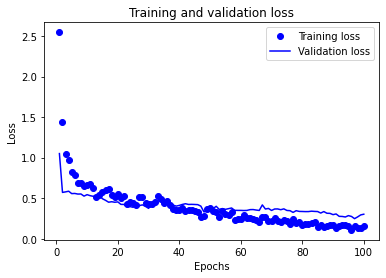

In [30]:
import matplotlib.pyplot as plt

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

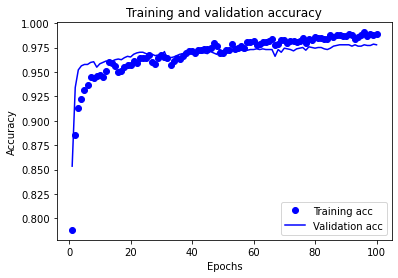

In [31]:
plt.clf()  # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
import seaborn as sn

In [35]:
confusion_matrix = tf.math.confusion_matrix(np.where(model.predict(test_docs)>=0,1,0), test_labels)

df_cm = pd.DataFrame(confusion_matrix.numpy(), index = ["Fake News","True News"],
                  columns = ["Fake News","True News"])

df_cm_percentual = pd.DataFrame(confusion_matrix.numpy()/confusion_matrix.numpy().sum(axis=1)[:,None], index = ["Fake News","True News"],
                  columns = ["Fake News","True News"])

<AxesSubplot:>

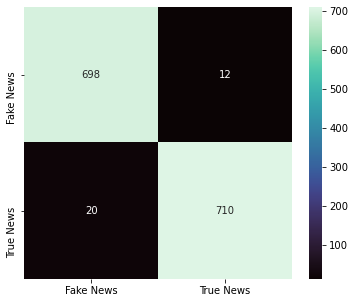

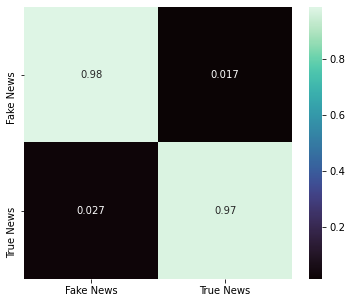

In [36]:
plt.figure(figsize = (6,5))
sn.heatmap(df_cm, annot=True,fmt='g',cmap = sn.color_palette("mako", as_cmap=True))
plt.figure(figsize = (6,5))
sn.heatmap(df_cm_percentual, annot=True,fmt='0.2g',cmap = sn.color_palette("mako", as_cmap=True))
